### Домашнє завдання: Пониження розмірностей для Аналізу Портретів Клієнтів

#### Контекст
В цьому ДЗ ми попрацюємо з методами пониження розмірності на наборі даних для задачі аналізу портретів клієнтів (Customer Personality Analysis). **В попередньому ДЗ ми працювали з цими даними використовуючи кластеризацію, зараз використаємо кластеризацію і візуалізауємо результати з різними методами.**

Customer Personality Analysis - це аналіз різних сегментів клієнтів компанії. Цей аналіз дозволяє бізнесу краще розуміти своїх клієнтів і полегшує процес адаптації продуктів під конкретні потреби, поведінку та інтереси різних типів клієнтів.

Аналіз портретів клієнтів допомагає бізнесу змінювати свій продукт на основі цільової аудиторії, розділеної на різні сегменти. Наприклад, замість того, щоб витрачати гроші на маркетинг нового продукту для всіх клієнтів у базі даних компанії, бізнес може проаналізувати, який сегмент клієнтів найімовірніше придбає продукт, і потім зосередити маркетингові зусилля лише на цьому сегменті.

#### Вхідні дані
Вам надано набір даних з такими атрибутами:

**Характеристики користувачів:**
- `ID`: Унікальний ідентифікатор клієнта
- `Year_Birth`: Рік народження клієнта
- `Education`: Рівень освіти клієнта
- `Marital_Status`: Сімейний стан клієнта
- `Income`: Річний дохід домогосподарства клієнта
- `Kidhome`: Кількість дітей у домогосподарстві клієнта
- `Teenhome`: Кількість підлітків у домогосподарстві клієнта
- `Dt_Customer`: Дата реєстрації клієнта у компанії
- `Recency`: Кількість днів з моменту останньої покупки клієнта
- `Complain`: 1, якщо клієнт скаржився за останні 2 роки, 0 - якщо ні

**Продукти:**
- `MntWines`: Сума, витрачена на вино за останні 2 роки
- `MntFruits`: Сума, витрачена на фрукти за останні 2 роки
- `MntMeatProducts`: Сума, витрачена на м'ясні продукти за останні 2 роки
- `MntFishProducts`: Сума, витрачена на рибні продукти за останні 2 роки
- `MntSweetProducts`: Сума, витрачена на солодощі за останні 2 роки
- `MntGoldProds`: Сума, витрачена на золото за останні 2 роки

**Акції:**
- `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
- `AcceptedCmp1`: 1, якщо клієнт прийняв пропозицію у першій кампанії, 0 - якщо ні
- `AcceptedCmp2`: 1, якщо клієнт прийняв пропозицію у другій кампанії, 0 - якщо ні
- `AcceptedCmp3`: 1, якщо клієнт прийняв пропозицію у третій кампанії, 0 - якщо ні
- `AcceptedCmp4`: 1, якщо клієнт прийняв пропозицію у четвертій кампанії, 0 - якщо ні
- `AcceptedCmp5`: 1, якщо клієнт прийняв пропозицію у п'ятій кампанії, 0 - якщо ні
- `Response`: 1, якщо клієнт прийняв пропозицію в останній кампанії, 0 - якщо ні

**Взаємодія з компанією:**
- `NumWebPurchases`: Кількість покупок, зроблених через вебсайт компанії
- `NumCatalogPurchases`: Кількість покупок, зроблених за каталогом
- `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
- `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць


Для початку, запустіть код нижче. Всі ці кроки ми робили в попередньому ДЗ і для того, щоб результати кластеризації у нас були схожими, потрібно аби передобробка була однаковою.

### Imports

In [35]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Load and preprocessing data

In [36]:
# 1. Завантаження даних
df = pd.read_csv('./data/marketing_campaign.csv', sep='\t')

# 2. Обробка пропущених значень
df['Income_not_filled'] = df.Income.isna()
df.Income = df.Income.fillna(-1)

# 3. Обробка дати реєстрації
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y')
today = df.Dt_Customer.max()
df['days_lifetime'] = (today - df.Dt_Customer).dt.days
df['years_customer'] = df.Year_Birth.apply(lambda x: today.year - x)

# 4. Категоризація рівня освіти
df_education = pd.get_dummies(df.Education, prefix='education').astype(int)
df = pd.concat([df, df_education], axis=1)

# 5. Очищення сімейного стану
marital_status_map = {'Alone': 'Single', 'Absurd': 'Else', 'YOLO': 'Else'}
df['Marital_Status_clean'] = df.Marital_Status.map(marital_status_map)
df_ms = pd.get_dummies(df.Marital_Status_clean, prefix='marital').astype(int)
df = pd.concat([df, df_ms], axis=1)

# 6. Форматування доходу і видалення викиду
df.Income = df.Income.astype(int)
df = df[df.Income != 666666]

# 7. Створення фінального набору даних
X = df.drop(['ID', 'Dt_Customer', 'Education', 'Marital_Status', 'Marital_Status_clean'], axis=1)
X.reset_index(drop=True, inplace=True)

### Завдання 1: Виконання кластеризації та пониження розмірності для візуалізації результатів

Ваше завдання — провести кластеризацію клієнтів та візуалізувати результати кластеризації, використовуючи метод головних компонент (PCA) для пониження розмірності даних.

#### Інструкції:

1. **Вибір ключових характеристик:**
   Давайте обмежимось тільки наступними хараткеристиками для кластеризації цього разу:
   - `Income`: Річний дохід домогосподарства клієнта
   - `Recency`: Кількість днів з моменту останньої покупки клієнта
   - `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
   - `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
   - `days_lifetime`: Кількість днів з моменту реєстрації клієнта у компанії
   - `years_customer`: Вік клієнта
   - `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць
   
   Відберіть в наборі даних `X` лише ці характеристики.

2. **Нормалізація даних:**
   Використайте метод `MinMaxScaler` для нормалізації значень обраних характеристик.

3. **Кластеризація:**
   Проведіть кластеризацію клієнтів, використовуючи метод `KMeans` з трьома кластерами.

4. **Пониження розмірності:**
   Використайте метод головних компонент (PCA) для пониження розмірності даних до трьох компонент.

5. **Візуалізація результатів:**
   Використовуючи plolty express побудуйте 3D-графік розподілу клієнтів у просторі трьох головних компонент, де кольором позначено кластери.

6. **Опишіть, що спостерігаєте:**
   Чи кластеризація чітко розділила дані?

Далі ми детальніше проінтерпретуємо результати візуалізації і пониження розмірностей.

In [37]:
features = ['Income', 'Recency', 'NumStorePurchases', 'NumDealsPurchases',
            'days_lifetime', 'years_customer', 'NumWebVisitsMonth']

X_short = X[features].copy()

In [38]:
X_short_scaled = MinMaxScaler().fit_transform(X_short)

In [39]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_short_scaled)
cluster_labels

array([2, 0, 1, ..., 1, 1, 0])

In [40]:
pca = PCA(n_components=3, random_state=42)
pca_data = pca.fit_transform(X_short_scaled)

In [41]:
# Create a DataFrame for Plotly Express
df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2', 'PC3'])
df['cluster'] = cluster_labels

In [42]:
fig = px.scatter_3d(
    df,
    x='PC1',
    y='PC2',
    z='PC3',
    hover_data='cluster',
    color='cluster',
    title='3D Scatter Plot of Dataset with PCA'
)

fig.update_traces(marker_size=3)
fig.update_layout(margin=dict(l=0, r=0, b=10, t=0))
fig.update_coloraxes(colorbar_tickvals=df['cluster'].unique())
fig.show()

The division into clusters is quite clear — instances from different clusters are well separated and do not overlap.

### Завдання 2: Аналіз результатів пониження розмірності

1. **Розрахунок частки поясненої дисперсії:**
   Визначте, яка частка загальної варіації даних пояснюється кожною з трьох головних компонент (PC1, PC2, PC3) за допомогою атрибуту `explained_variance_ratio_` об'єкта PCA. Виведіть результат на екран.

2. **Розрахунок кумулятивної частки поясненої дисперсії:**
   Обчисліть кумулятивну частку поясненої дисперсії для трьох головних компонент, щоб зрозуміти, скільки варіації даних пояснюється першими кількома компонентами.

In [43]:
var_exp = pca.explained_variance_ratio_
print("The explained variance ratio of each principal component is:", var_exp)

The explained variance ratio of each principal component is: [0.30203449 0.2866534  0.25122414]


In [44]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
print("The cumulative explained variance:", cum_var_exp)

The cumulative explained variance: [0.30203449 0.5886879  0.83991203]


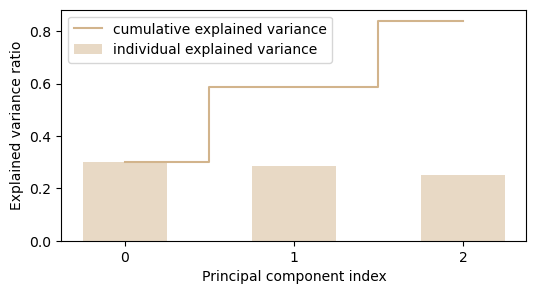

In [45]:
plt.figure(figsize=(6, 3))
plt.bar(range(3), var_exp, width=0.5, color='tan', alpha=0.5,
        label='individual explained variance')
plt.step(range(3), cum_var_exp, color='tan', where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(range(3))
plt.legend(loc='upper left')
plt.show()

The first three components explain 83% of all variance.

### Завдання 3: Інтерпретація "Loadings"

Продовжуємо інтерпретацію результатів `PCA`і познайомимось з новим поняттям `loadings`, яке допоможе нам знайти звʼязок між головними компонентами і оригінальними ознаками в наборі даних.

Ми зараз побудували візуалізацію кластерів точок даних в просторі трьох головних компонент. Але хочеться знайти звʼязок між головними компонентами і оригінальними ознаками. Для розуміння, які початкові характеристики даних мають найбільший вплив на ці головні компоненти, ми можемо використати атрибут `components_` методу `PCA`.

#### Що таке `pca.components_`?

`pca.components_` — це масив, який містить коефіцієнти (або "ваги"), що показують внесок кожної вихідної ознаки у кожну з головних компонент. Ці коефіцієнти ще називаються **"loading"** або "навантаженнями" компонент.

- **Loadings** (`навантаження`) відображають важливість кожної змінної (ознаки) для відповідної головної компоненти. Вони показують, яким чином змінні поєднуються, щоб утворити нові, зменшені вимірювання.
- Якщо коефіцієнт має високе абсолютне значення (як позитивне, так і негативне), це вказує на те, що відповідна змінна сильно впливає на головну компоненту.

#### Саме завдання
Ваше завдання — обчислити "навантаження" для кожної з головних компонент і інтерпретувати результати.

1. **Обчислення loadings для компонент:**
   Використайте атрибут `components_` об'єкта PCA для створення DataFrame, який відображатиме внесок кожної вихідної ознаки в кожну головну компоненту.

2. **Інтерпретація результатів:**
   Виведіть значення "навантажень" і проаналізуйте, які ознаки найбільше впливають на кожну головну компоненту.

In [46]:
pd.DataFrame(pca.components_.T,
             index=features,
             columns=['PC1', 'PC2', 'PC3']).style.background_gradient()

,PC1,PC2,PC3
Income,0.063557,-0.047082,0.373826
Recency,0.475786,0.878876,0.029910
NumStorePurchases,0.284282,-0.187195,0.816668
NumDealsPurchases,0.103049,-0.059324,-0.050687
days_lifetime,0.821912,-0.431061,-0.305490
years_customer,0.012658,0.001022,0.080411
NumWebVisitsMonth,0.049530,-0.031377,-0.300089


The most important features for each principal component:
- **PC1**: `days_lifetime`, `Recency`, `NumStorePurchases`
- **PC2**: `Recency`, `days_lifetime`
- **PC3**: `NumStorePurchases`, `Income`, `days_lifetime`, `NumWebVisitsMonth`

### Завдання 4.
Давайте проаналізуємо "навантаження" (**loadings**) для трьох головних компонент після вилучення ознаки `Income`. Це допоможе нам зрозуміти, як змінилася важливість інших ознак для кожної головної компоненти, коли одна з ключових характеристик (`Income`) була вилучена.

#### Кроки для проведення аналізу і ваше завдання:

1. Видаліть ознаку `Income` з нашого набору даних `X` і повторно виконайте PCA (метод головних компонент) для отримання нових "навантажень".

2. Обчисліть нові "навантаження" для трьох головних компонент на наборі даних без `Income`

3. Проаналізуйте, які ознаки мають найбільший вплив на кожну головну компоненту після вилучення `Income`.

4. Перегляньте, наскільки кожна з головних компонент пояснює дисперсію в даних без ознаки `Income`.

In [47]:
features_two = ['Recency', 'NumStorePurchases', 'NumDealsPurchases',
            'days_lifetime', 'years_customer', 'NumWebVisitsMonth']

X_short_no_income = X_short.drop(columns=['Income']).copy()

X_short_no_income_scaled = MinMaxScaler().fit_transform(X_short_no_income)

In [48]:
pca = PCA(n_components=3)
pca.fit(X_short_no_income_scaled)

pd.DataFrame(pca.components_.T,
             index=X_short_no_income.columns,
             columns=['PC1', 'PC2', 'PC3']).style.background_gradient()

,PC1,PC2,PC3
Recency,0.500712,0.865392,0.008648
NumStorePurchases,0.226953,-0.145537,0.924549
NumDealsPurchases,0.105012,-0.065833,-0.027582
days_lifetime,0.825793,-0.472036,-0.232275
years_customer,0.007110,0.005913,0.079808
NumWebVisitsMonth,0.069051,-0.052233,-0.289919


After removing `Income` from the feature set, the key features for each component remain the same, except for **PC3**:
- **PC1**: `days_lifetime`, `Recency`, `NumStorePurchases`
- **PC2**: `Recency`, `days_lifetime`
- **PC3**: `NumStorePurchases`, `NumWebVisitsMonth`, `days_lifetime`

In [15]:
var_exp = pca.explained_variance_ratio_
print("The explained variance ratio of each principal components:", var_exp)

The explained variance ratio of each principal components: [0.32149032 0.30545488 0.23446936]


In this case, the first and second components explain more variance in the data, while the third explains slightly less.

### Завдання 5: Візуалізація кластеризації за допомогою t-SNE

Ваше завдання — використати метод t-SNE для візуалізації результатів кластеризації клієнтів у двовимірному просторі. Метод t-SNE допомагає знизити розмірність даних та зберегти локальні структури в даних, що робить його ефективним для візуалізації високорозмірних даних. Ми також зможемо порівняти результат цього методу з РСА.

1. Використайте метод t-SNE для зниження розмірності до 2х вимірів даних, які включають ознаки всі, що і в завданні 1, а також були відмасштабовані перед пониженням розмірностей.

2. Створіть новий DataFrame з координатами, отриманими після застосування t-SNE, та додайте до нього мітки кластерів.

3. Побудуйте інтерактивний 2D-графік розподілу клієнтів, де кольором буде позначено різні кластери і проаналізуйте графік з рекомендаціями нижче (можливо треба буде вивести додаткові візуалізації чи таблиці для інтерпретації, але треба прям зрозуміти, які ознаки формують який кластер і чим кластери відрізняються одне від одного).

  **Опишіть отримані кластери з точки зору ознак.**

4. Опишіть відмінність графіка tSNE від PCA.

#### ЯК можна інтерпретувати з t-SNE?

Хоча t-SNE не надає "компонентів" як РСА, він забезпечує низьковимірне представлення даних, яке можна візуально інтерпретувати:

- **Кластери:** t-SNE особливо добре показує кластери подібних точок. Якщо ви бачите чітко визначені кластери на графіку t-SNE, це свідчить про наявність груп схожих спостережень у ваших даних. Проаналізувати їх можемо, якщо додамо дані в `hover_data` або якщо якісь з даних виведемо як розмір чи форма точок на візуалізації. Також корисно може бути вивести середні значення ознак по кластерам.
- **Локальна структура:** Відносне розташування точок одного кластеру на графіку t-SNE може допомогти вам зрозуміти, які дані подібні між собою.
- **Глобальна структура:** Будьте обережні; t-SNE менш надійний для відображення глобальних структур (наприклад, відстаней між кластерами) у порівнянні з PCA, бо t-SNE націлений на збереження саме локальних структур.

In [68]:
tsne = TSNE(n_components=2, random_state=42).fit_transform(X_short_scaled)

In [69]:
df_tsne = pd.DataFrame(tsne, columns=['X_tsne', 'y_tsne'])
df_tsne['cluster'] = cluster_labels
df_tsne.head()

,X_tsne,y_tsne,cluster
0,8.067192,-32.077393,2
1,-42.219307,10.015425,0
2,-5.699414,-13.273088,1
3,-49.260719,2.251561,0
4,-6.261353,30.357811,2


In [71]:
df_tsne = pd.concat([df_tsne, X_short], axis=1)


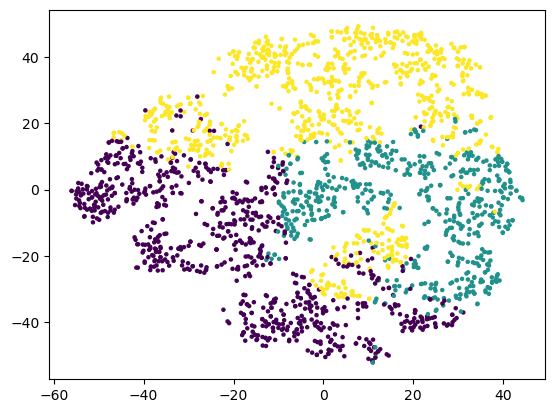

In [ ]:
plt.scatter(df_tsne['X_tsne'], df_tsne['y_tsne'], c=df_tsne['cluster'], s=3)
plt.show()

In [72]:
fig = px.scatter(df_tsne, 'X_tsne', 'y_tsne', 'cluster',
                 hover_data=features)
fig.update_coloraxes(colorbar_tickvals=df_tsne['cluster'].unique())
fig.show()

In [28]:
X_short['cluster'] = cluster_labels
X_short.groupby('cluster')[features].mean()

,Income,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
cluster,,,,,,,
0,44990.324561,21.352130,4.264411,2.327068,337.989975,43.987469,5.849624
1,69681.154622,51.163025,10.275630,2.273950,398.705882,46.610084,3.880672
2,44622.521277,73.878251,4.078014,2.356974,336.508274,45.346336,5.822695


Clusters in the t_SNE are not clearly separated. We observe overlapping, and part of the points from Cluster 2 are isolated from the rest of the same cluster.

Cluster 1 include clients with higher `Income` and `NumStorePurcahses`, and lower `NumWebVisitsMonth`.

Cluster 0 and 2 have more overlapping points. The most significant difference between these clusters lies in the `Recency` feature, while the mean values of other features are very similar.